# Access and plot AROME MetCoOp and ECMWF IFS forecasts
## Example for an extreme precipitation event in October 2014 in West Norway

In [9]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import cartopy as cy
from cmcrameri import cm


##### Specifiy input fields: AROME MetCoOp and ECMWF IFS forecasts

In [10]:
day='26'; month='10'; year='2014'; HH='12'

url='https://thredds.met.no/thredds/dodsC/aromemetcoopstarc/'+str(year)+'/'+str(month)+'/'+str(day)+'/AROME_MetCoOp_'+str(HH)+'_fp.nc_'+str(year)+str(month)+str(day)
arome = xr.open_dataset(url)

url='https://thredds.met.no/thredds/dodsC/metusers/maltem/GEO4902_2020/Arctic.ECMWF_extracted_'+str(year)+str(month)+str(day)+'T'+str(HH)+'Z.nc'
ecifs =  xr.open_dataset(url)

### Find a specific point and plot the forecast. 
###### Note AROME MetCoOp is on an irregular grid, so the xarray.sel functionality does not work. But it does work for the ECMWF IFS grid (see below)

In [11]:
def findindex(alat,alon,plat,plon):
    #finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslon,abslat)
    x, y = np.where(c == np.min(c))
    #print(alats[x,y],alon[x,y])
    x=int(x)
    y=int(y)
   
    return (x,y)

In [12]:
lat0=60.3833; lon0=5.9500 # Kvamskogen in Western Norway

[ix,jx] = findindex(arome.latitude,arome.longitude,lat0,lon0) # from regional model AROME MetCoOp


### The ECMWF IFS precipitation is subdivided into large scale or stratiform precipitation (LSP) and convective precipitation (TP-LSP)

In [13]:
ecifs

<xarray.Dataset>
Dimensions:  (time: 67, lon: 961, lat: 256)
Coordinates:
  * time     (time) datetime64[ns] 2014-10-26T12:00:00 ... 2014-10-29T06:00:00
  * lon      (lon) float64 -60.0 -59.88 -59.75 -59.62 ... 59.62 59.75 59.88 60.0
  * lat      (lat) float64 57.06 57.19 57.31 57.44 ... 88.56 88.69 88.81 88.94
Data variables:
    SP       (time, lat, lon) float32 ...
    U10M     (time, lat, lon) float32 ...
    V10M     (time, lat, lon) float32 ...
    T2M      (time, lat, lon) float32 ...
    TP       (time, lat, lon) float32 ...
    LSP      (time, lat, lon) float32 ...
Attributes:
    CDI:                             Climate Data Interface version 1.9.8 (ht...
    Conventions:                     CF-1.6
    history:                         Tue Jun 30 14:30:09 2020: cdo -sellonlat...
    institution:                     European Centre for Medium-Range Weather...
    CDO:                             Climate Data Operators version 1.9.8 (ht...
    DODS_EXTRA.Unlimited_Dimension:  time

In [14]:
pp_acc_point_arome = arome.precipitation_amount_acc.isel(height0=0,x=ix,y=jx)
pp_acc_point_ecifs = ecifs.sel(lat=lat0,lon=lon0,method='nearest')

Text(0.5, 1.0, 'Kvamskogen Accumulated Precipitation Forecast')

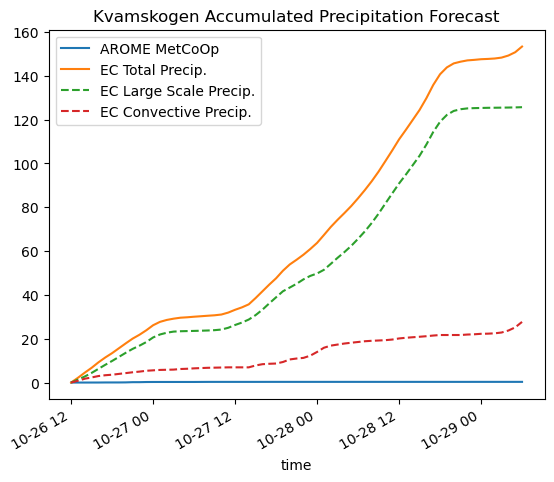

In [15]:
pp_acc_point_arome.plot(x='time', linestyle='-', label='AROME MetCoOp')
(pp_acc_point_ecifs.TP*1000).plot(x='time', linestyle='-',label='EC Total Precip.')
(pp_acc_point_ecifs.LSP*1000).plot(x='time', linestyle='--',label='EC Large Scale Precip.')
((pp_acc_point_ecifs.TP-pp_acc_point_ecifs.LSP)*1000).plot(x='time',linestyle='--',label='EC Convective Precip.')

plt.legend()
plt.title("Kvamskogen Accumulated Precipitation Forecast")


### Plot the two accumulated precipitation forecasts on a map

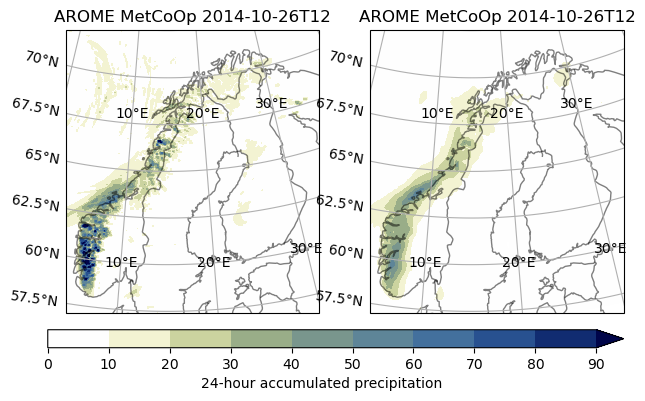

In [16]:
timestep=24 # 24-hour accumulated precipitation
levelsPP = range(0,100,10)


projection = cy.crs.LambertConformal(central_longitude =arome.projection_lambert.longitude_of_central_meridian,
                                       central_latitude  =arome.projection_lambert.latitude_of_projection_origin,
                                       standard_parallels = arome.projection_lambert.standard_parallel)
f, axsm = plt.subplots(1,2, subplot_kw={'projection' : projection}, figsize=(7.2,7.2), sharex=True, sharey=True)

for ax in axsm.flatten():
    ax.set_extent([5, 30, 57, 72], cy.crs.PlateCarree())
    ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
    ax.add_feature(cy.feature.BORDERS, alpha=0.5)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels   = False
    gl.right_labels = False
    
arome.precipitation_amount_acc.isel(time=timestep,height0=0).plot.contourf(ax=axsm[0], transform=projection, cmap=cm.davos_r, extend='max',levels=levelsPP,add_colorbar=False)
axsm[0].set_title('AROME MetCoOp '+np.datetime_as_string(arome.time[0],unit='h'))

cf = (ecifs.TP.isel(time=timestep)*1000).plot.contourf(ax=axsm[1], transform=cy.crs.PlateCarree(), cmap=cm.davos_r, extend='max', levels=levelsPP, add_colorbar=False)
axsm[1].set_title ('AROME MetCoOp '+np.datetime_as_string(arome.time[0],unit='h'))

cbaxes = f.add_axes([0.1, 0.25, 0.8, 0.025])
cbar = plt.colorbar(cf, cax=cbaxes, shrink=0.5, orientation='horizontal', extend='max',label='24-hour accumulated precipitation')
  
